In [1]:
import pyFAI
import fabio
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os, re
def clearPyFAI_header(file):
    x,y,e = np.loadtxt(file,unpack = True, comments = '#')
    np.savetxt(file,np.array([x,y,e]).transpose(), '%.6f')
    

<IPython.core.display.Javascript object>


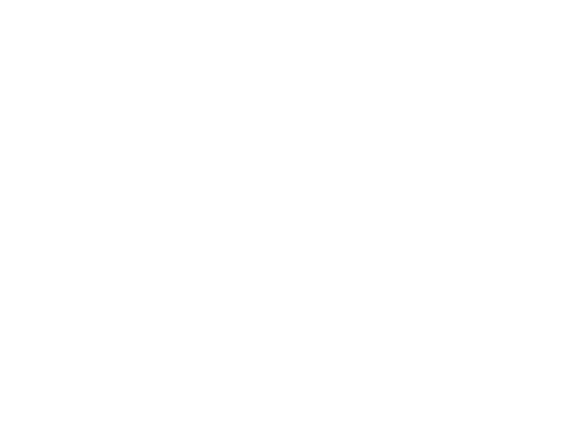

In [2]:
%matplotlib nbagg

direc = r'C:\Users\kenneth1a\Documents\beamlineData\a311189_pdf\44_empty_B1mm\pdf\xrd/' # Directory of xrd files
os.chdir(direc)

dest = direc
if not os.path.exists(dest):
    os.makedirs(dest)

mask  = r'C:\Users\kenneth1a\Documents\beamlineData\a311189_pdf\dtx0_dtr15_baseMask_lines.edf' # Mask file
mask = fabio.open(mask).data
poni  = r'C:\Users\kenneth1a\Documents\beamlineData\a311189_pdf\Si_0_15tilt.poni' # Poni file
poni = pyFAI.load(poni)
gainFile = r'C:\Users\kenneth1a\Documents\maskGenerator/calculatedGainMap_48p6keV_kpm_filtered.edf'

gainArray = fabio.open(gainFile).data


files = glob('*.cbf')
i1 = fabio.open(files[0]).data
dataset = np.empty(shape = (*i1.shape,len(files)))

doMonitor = True

monitorfile = glob('*.dat')[0]
monitor = np.loadtxt(monitorfile,usecols = 2, skiprows = 1)

scale = 10**9
for c,file in enumerate(files):
    
    array = fabio.open(file).data
    if doMonitor:
        array = (array/monitor[c])*scale
    dataset[:,:,c] = array
    
    vmax = np.percentile(np.where(np.isnan(array),0,array),99.9)
    #plt.figure()
    #plt.imshow(array,vmax = vmax)
    #plt.colorbar()
average = np.average(dataset,axis=2)
median = np.median(dataset,axis=2)
vmax = np.percentile(np.where(np.isnan(average),0,average),99.9)
plt.figure()
plt.imshow(average,vmax = vmax)
plt.colorbar()

<IPython.core.display.Javascript object>


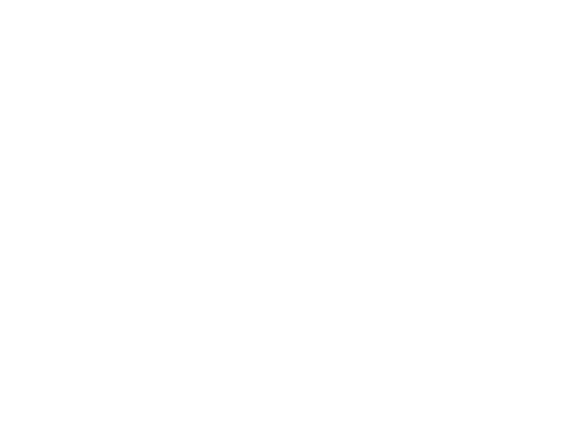

In [3]:
plt.figure()
stdev = np.std(dataset,axis = 2)
vmax = np.percentile(np.where(np.isnan(stdev),0,stdev),99.9)
plt.imshow(np.std(dataset,axis = 2),vmax = vmax)
plt.colorbar()

empty_B1mm_pdf_001_dtx_0_0001p.cbf


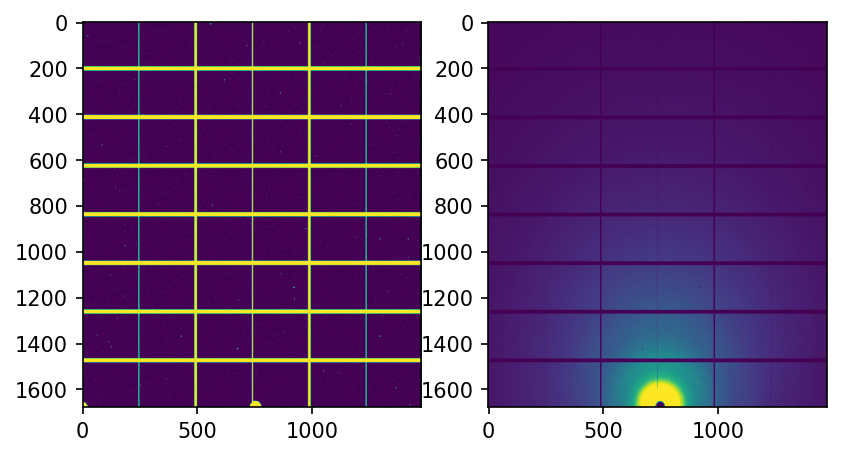

empty_B1mm_pdf_001_dtx_0_0002p.cbf


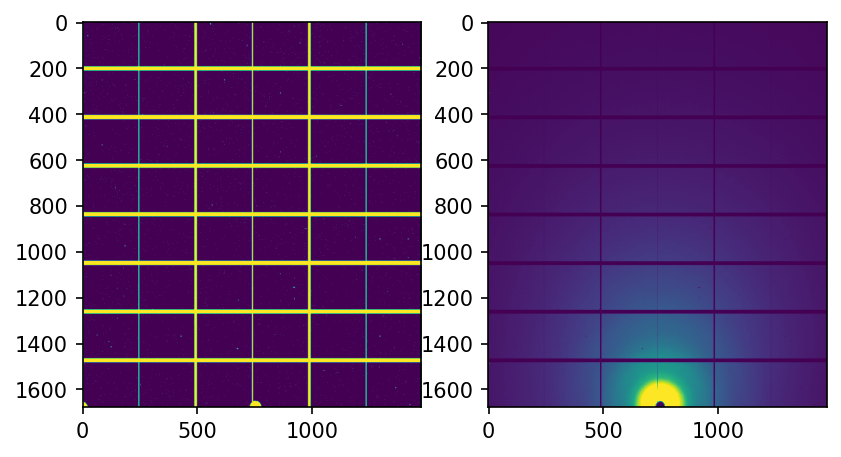

empty_B1mm_pdf_001_dtx_0_0003p.cbf


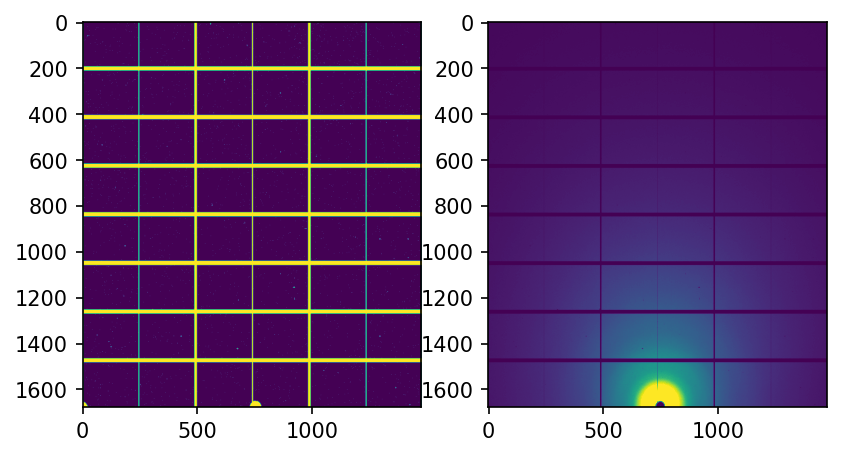

empty_B1mm_pdf_001_dtx_0_0004p.cbf


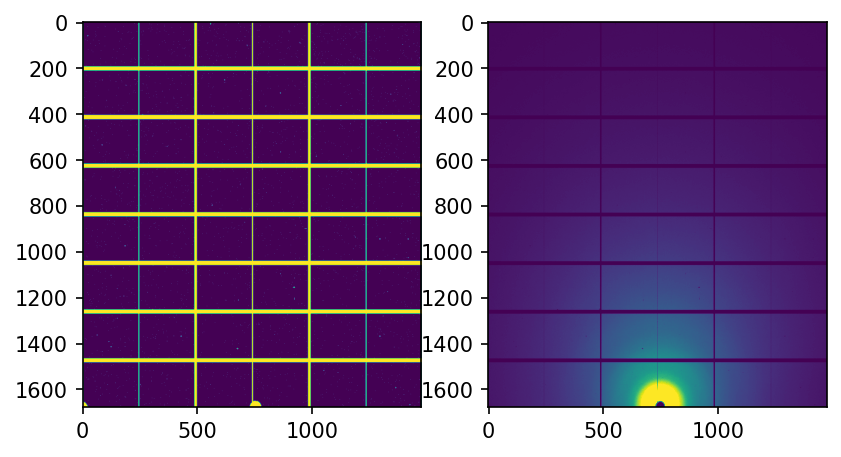

empty_B1mm_pdf_001_dtx_0_0005p.cbf


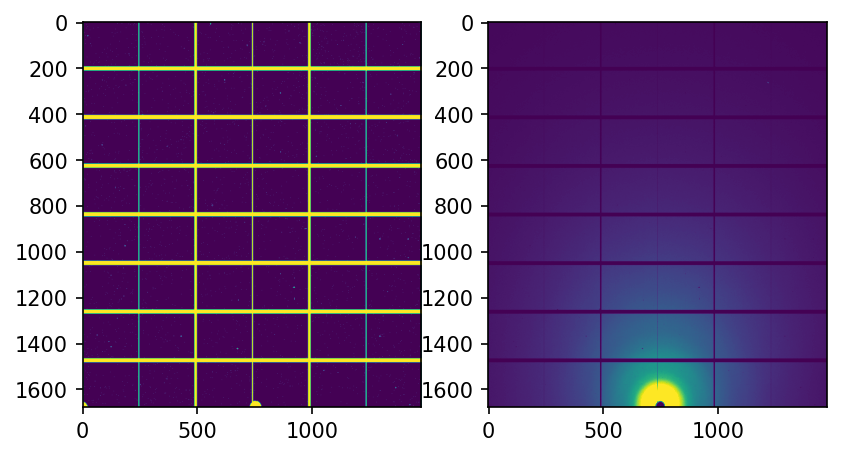

empty_B1mm_pdf_001_dtx_0_0006p.cbf


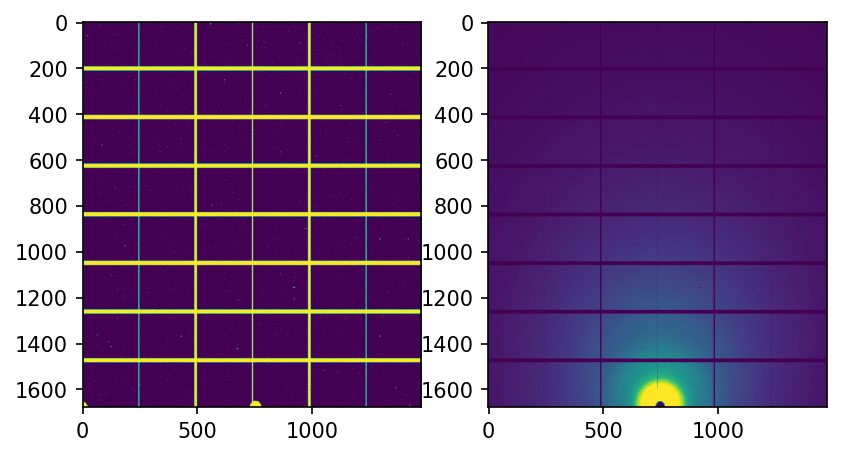

empty_B1mm_pdf_001_dtx_0_0007p.cbf


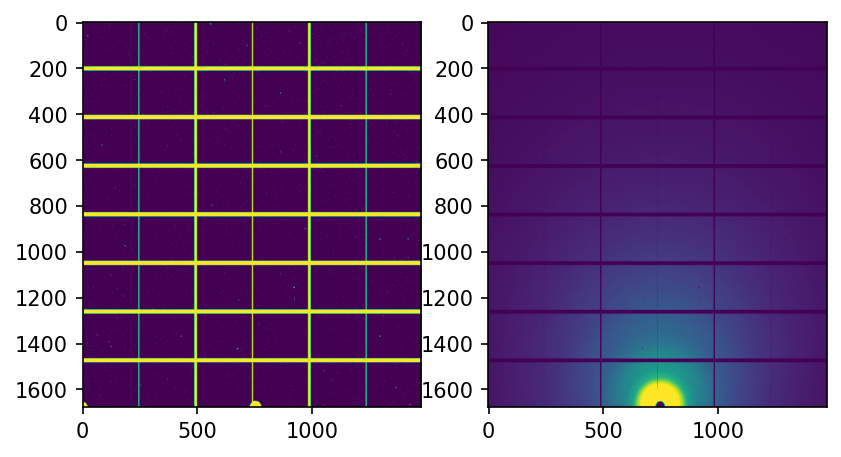

empty_B1mm_pdf_001_dtx_0_0008p.cbf


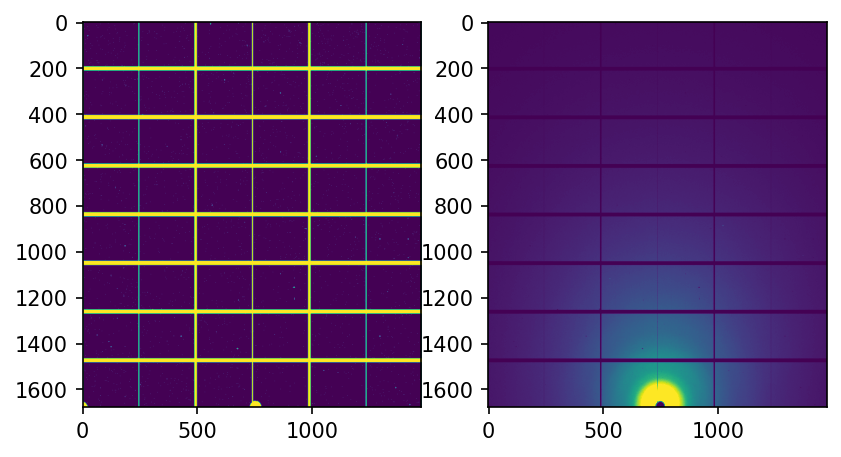

empty_B1mm_pdf_001_dtx_0_0009p.cbf


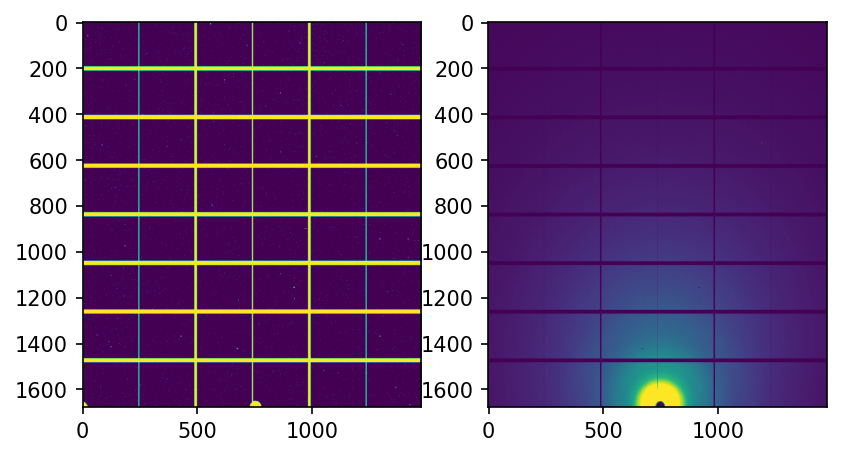

empty_B1mm_pdf_001_dtx_0_0010p.cbf


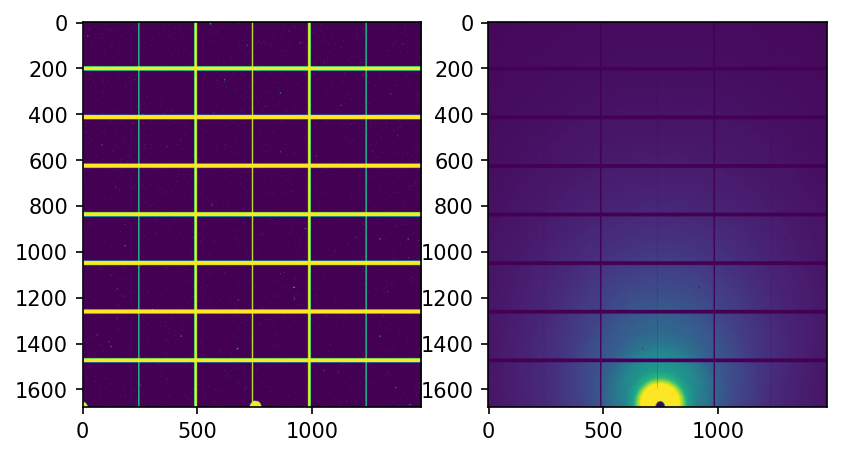

empty_B1mm_pdf_001_dtx_0_0011p.cbf


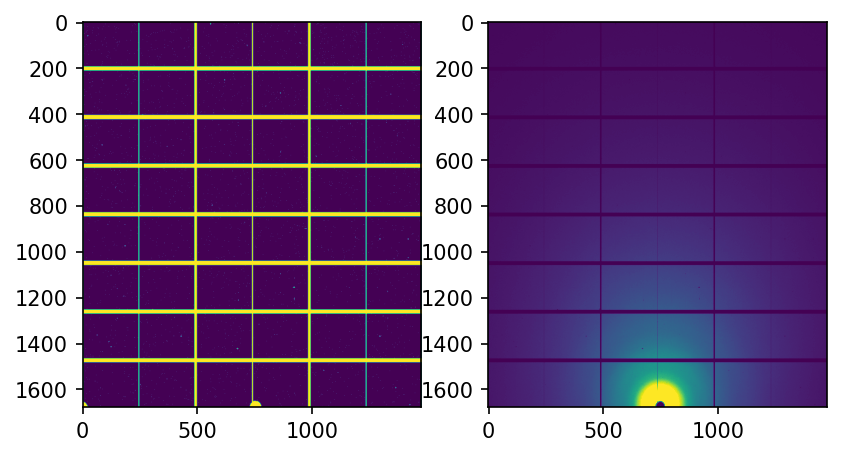

empty_B1mm_pdf_001_dtx_0_0012p.cbf


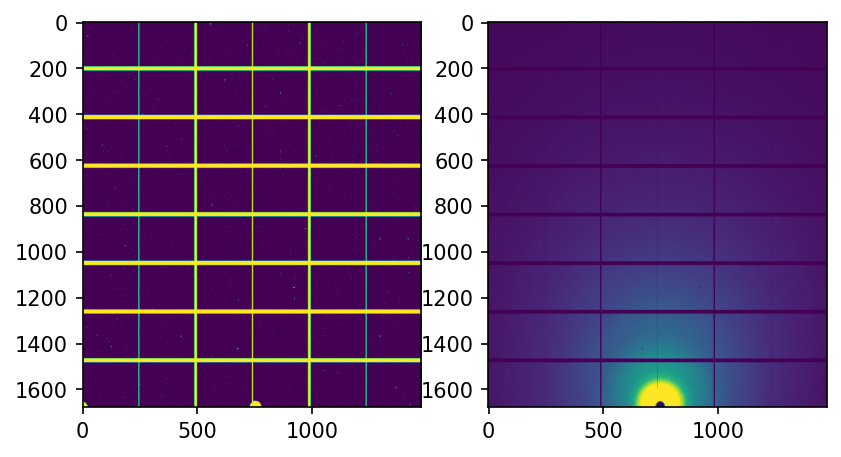

empty_B1mm_pdf_001_dtx_0_0013p.cbf


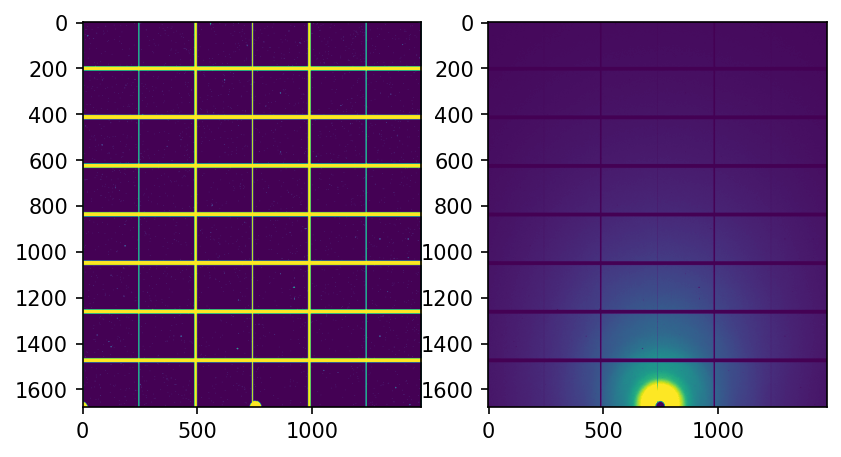

empty_B1mm_pdf_001_dtx_0_0014p.cbf


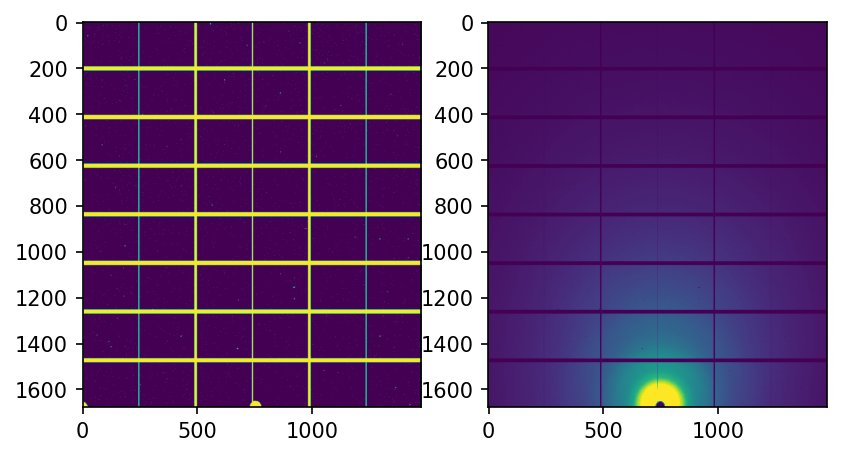

empty_B1mm_pdf_001_dtx_0_0015p.cbf


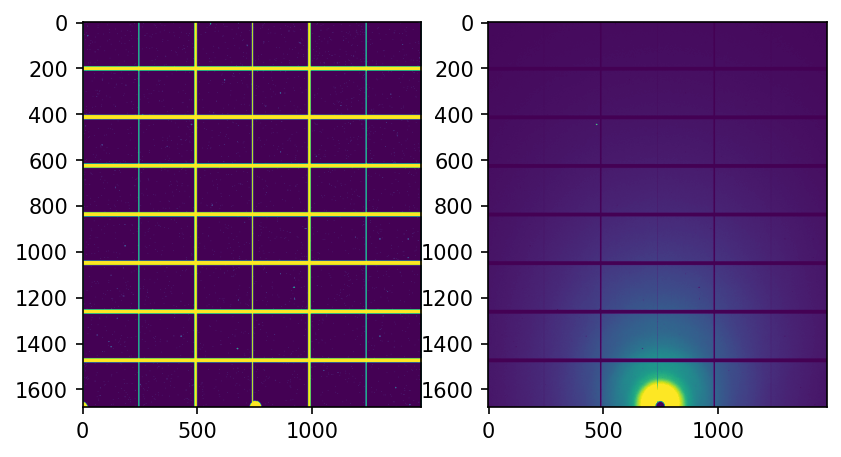

empty_B1mm_pdf_001_dtx_0_0016p.cbf


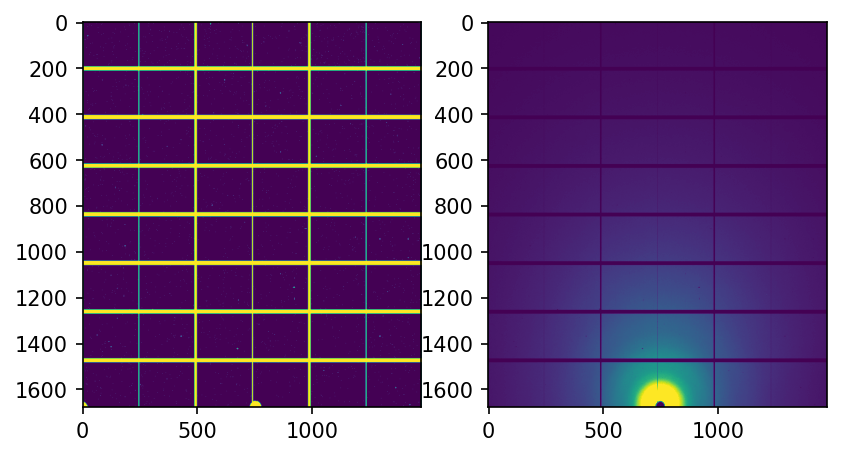

empty_B1mm_pdf_001_dtx_0_0017p.cbf


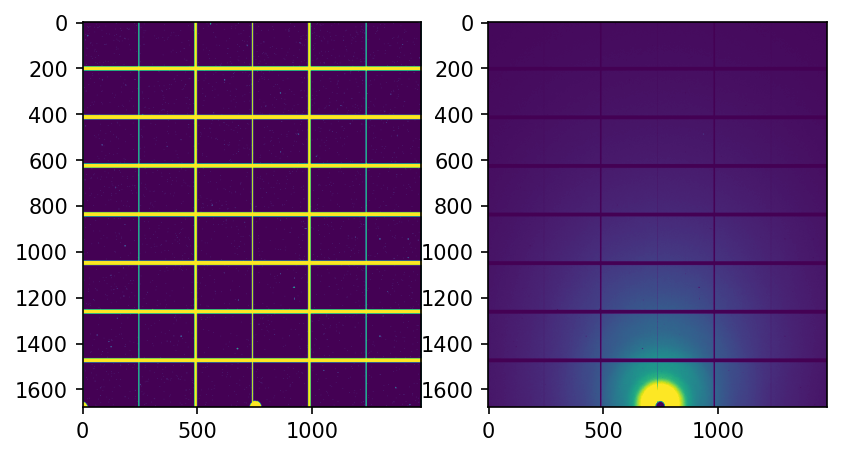

empty_B1mm_pdf_001_dtx_0_0018p.cbf


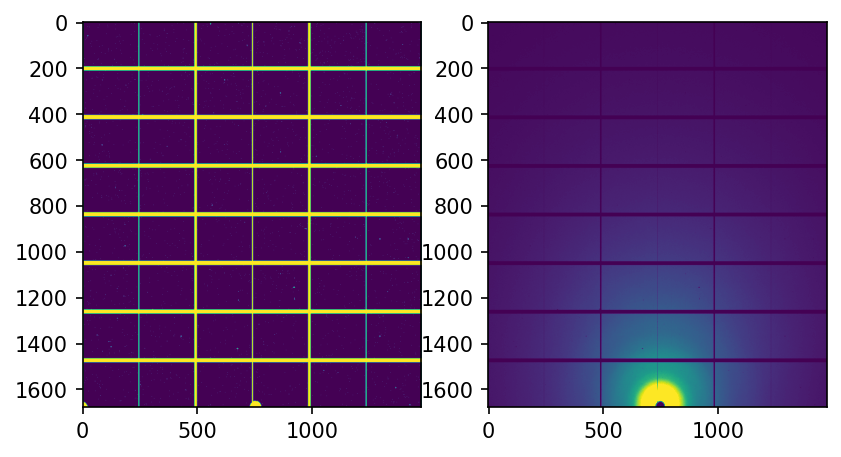

empty_B1mm_pdf_001_dtx_0_0019p.cbf


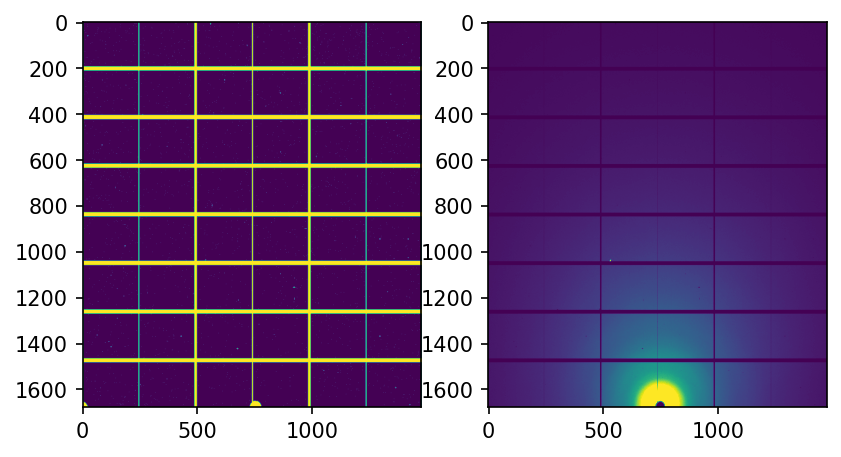

empty_B1mm_pdf_001_dtx_0_0020p.cbf


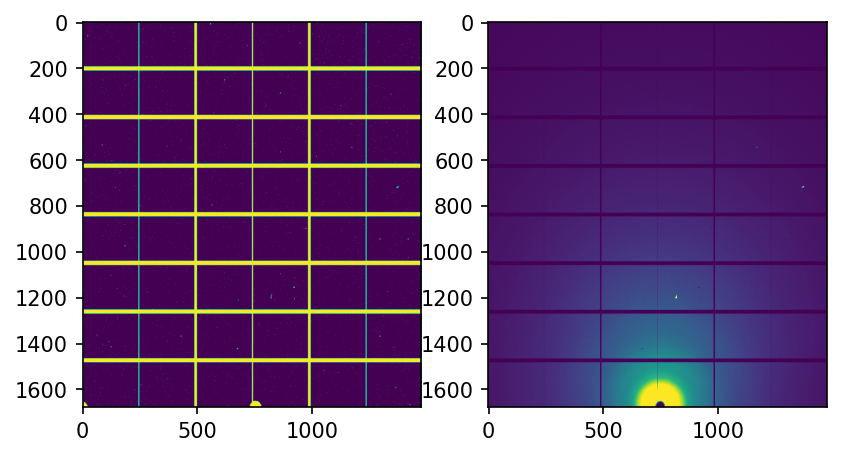

In [4]:
%matplotlib inline
maskdct = {}
nstdevs = 3
for c in range(len(files)):
    print(files[c])
    array = dataset[:,:,c]
    vmax = np.percentile(np.where(np.isnan(array),0,array),99.5)
    maskdct[c] = np.where(array > median+nstdevs*stdev,1,mask)
    fig,ax = plt.subplots(1,2,dpi = 150)
    ax[0].imshow(maskdct[c])
    ax[1].imshow(array,vmax = vmax)
    plt.show()

In [6]:
subdir = f'xye_{nstdevs}stdevs/'
subdirGain = f'xye_{nstdevs}stdevs_gainCorrected/'
clearHeader = True

if not os.path.exists(f'{dest}/average/xye/'):
    os.makedirs(f'{dest}/average/xye/')

dataset2 = np.empty(shape = dataset.shape)
for n in maskdct:
    dataset2[:,:,n] = np.where(maskdct[n] == 0, dataset[:,:,n], np.nan)
avim = np.nanmean(dataset2, axis = 2)
avim = np.where(np.isnan(avim), -2, avim)
im = fabio.cbfimage.CbfImage(avim)
im.save(f'{dest}/average/average.cbf')

avimGain = avim/gainArray
avimGain = np.where(gainArray <0, -1, avimGain)
imGain = fabio.cbfimage.CbfImage(avimGain)
imGain.save(f'{dest}/average/average_gainCorrected.cbf')



outfile = f'{dest}/average/xye/average.xye'
outfile_2d = outfile.replace('.xye','_pyfai.edf')
mask_av = np.where(avim < 0, 1, 0)
mask_avGain = np.where(avimGain < 0, 1, 0)
poni.integrate1d(data = avim, filename = outfile,mask = mask_av,polarization_factor = 0.99,unit = '2th_deg',
                correctSolidAngle = True, method = 'bbox',npt = 5000, error_model = 'poisson', safe = False)
poni.integrate2d(data = avim, filename = outfile_2d,mask = mask_av,polarization_factor = 0.99,unit = '2th_deg',
                correctSolidAngle = True, method = 'bbox',npt_rad = 5000,npt_azim = 360, error_model = 'poisson', safe = False)

outfileGC = f'{dest}/average/xye/average_gainCorrected.xye'
poni.integrate1d(data = avimGain, filename = outfileGC,mask =mask_avGain,polarization_factor = 0.99,unit = '2th_deg',
                correctSolidAngle = True, method = 'bbox',npt = 5000, error_model = 'poisson', safe = False)
outfileGC_2d = outfileGC.replace('.xye','_pyfai.edf')
result = poni.integrate2d(data = avimGain, filename = outfileGC_2d,mask = mask_avGain,polarization_factor = 0.99,unit = '2th_deg',
                correctSolidAngle = True, method = 'bbox',npt_rad = 5000,npt_azim = 360, error_model = 'poisson', safe = False)
clearPyFAI_header(outfile)
clearPyFAI_header(outfileGC)



if not os.path.exists(f'{dest}/{subdir}/average/'):
    os.makedirs(f'{dest}/{subdir}/average/')
if not os.path.exists(f'{dest}/{subdirGain}/average/'):
    os.makedirs(f'{dest}/{subdirGain}/average/')  
for c,file in enumerate(files):
    print(file)
    xyefile = file.replace('.cbf','.xye')
    outputfile = f'{dest}/{subdir}/{xyefile}'
    x,y,e = poni.integrate1d(data = dataset[:,:,c], filename = outputfile,mask = maskdct[c],polarization_factor = 0.99,unit = '2th_deg',
                    correctSolidAngle = True, method = 'bbox',npt = 5000, error_model = 'poisson', safe = False)

    outputfileGC = f'{dest}/{subdirGain}/{xyefile}'
    arrayGC = dataset[:,:,c]/gainArray
    arrayGC = np.where(gainArray < 0, -1, arrayGC)
    poni.integrate1d(data = arrayGC, filename = outputfileGC,mask = maskdct[c],polarization_factor = 0.99,unit = '2th_deg',
                    correctSolidAngle = True, method = 'bbox',npt = 5000, error_model = 'poisson', safe = False)
       
    if clearHeader:
        clearPyFAI_header(outputfile)
        clearPyFAI_header(outputfileGC)

    xg,yg,eg = np.loadtxt(outfileGC,comments = '#',unpack = True)
    if c == 0:
        av1d = np.empty(shape = (len(y),len(files)))
        av1dg = np.empty(shape = (len(yg),len(files)))
        eav = np.empty(shape = (len(y),len(files)))
        eavg = np.empty(shape = (len(yg),len(files)))
    av1d[:,c] = y
    av1dg[:,c] = yg
    eav[:,c] = e
    eavg[:,c] = eg
av1d = np.average(av1d,axis=1)
av1dg = np.average(av1dg,axis=1)
eav = np.average(eav,axis = 1)
eavg = np.average(eavg,axis = 1)
np.savetxt(f'{dest}{subdir}average/{xyefile}',np.array([x,av1d,eav]).transpose())
np.savetxt(f'{dest}{subdirGain}average/{xyefile}',np.array([xg,av1dg,eavg]).transpose())
qav = av1d*4*np.pi*np.sin(x*np.pi/(180*2))/0.25509
qavg = av1dg*4*np.pi*np.sin(xg*np.pi/(180*2))/0.25509
np.savetxt(f'{dest}{subdir}average/qav.xy',np.array([x,qav]).transpose())
np.savetxt(f'{dest}{subdirGain}average/qav.xy',np.array([xg,qavg]).transpose())


C:\Users\kenneth1a\AppData\Local\Temp\ipykernel_15340\2131541999.py:11: RuntimeWarning: Mean of empty slice
  avim = np.nanmean(dataset2, axis = 2)


(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([ 0.92879383,  0.94242705,  0.95606027, ..., 69.05397039,
       69.06760361, 69.08123682]), array([-179.50002538, -178.50006613, -177.50010687, -176.50014762,
       -175.50018836, -174.50022911, -173.50026985, -172.5003106 ,
       -171.50035134, -170.50039209, -169.50043283, -168.50047358,
       -167.50051432, -166.50055507, -165.50059581, -164.50063656,
       -163.5006773 , -162.50071805, -161.50075879, -160.50079954,
       -159.50084028, -158.50088103, -157.50092177, -156.50096252,
       -155.50100326, -154.50104401, -153.50108475, -152.5011255 ,
       -151.50116624, -150.50120699, -149.50124773, -148.50128848,
       -147.50132922, -146.50136997, -145.50141071, -144.50145146,
       -143.5014922 , -142.50153295, -14

"\nif not os.path.exists(f'{dest}/{subdir}/average/'):\n    os.makedirs(f'{dest}/{subdir}/average/')\nif not os.path.exists(f'{dest}/{subdirGain}/average/'):\n    os.makedirs(f'{dest}/{subdirGain}/average/')  \nfor c,file in enumerate(files):\n    print(file)\n    xyefile = file.replace('.cbf','.xye')\n    outputfile = f'{dest}/{subdir}/{xyefile}'\n    poni.integrate1d(data = dataset[:,:,c], filename = outputfile,mask = maskdct[c],polarization_factor = 0.99,unit = '2th_deg',\n                    correctSolidAngle = True, method = 'bbox',npt = 5000, error_model = 'poisson', safe = False)\n\n    outputfileGC = f'{dest}/{subdirGain}/{xyefile}'\n    arrayGC = dataset[:,:,c]/gainArray\n    arrayGC = np.where(gainArray < 0, -1, arrayGC)\n    poni.integrate1d(data = arrayGC, filename = outputfileGC,mask = maskdct[c],polarization_factor = 0.99,unit = '2th_deg',\n                    correctSolidAngle = True, method = 'bbox',npt = 5000, error_model = 'poisson', safe = False)\n       \n    if cle